In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# The function used to generate data, the Runge function
def Runge_func(x):
    return 1.0/(1 + 25*x**2)

In [1]:
# Functions used

def polynomial_features(x, p, intercept=False):
    """
    Take an array of x values, and the desired polynomial degree p.
    Create a feature (design) matrix with first column x**1, second column with x**2, and so on. I.e. the i-th column containing x**(i+1).
    Intercept=True will turn the first column into ones, meaning the i-th column will contain the value x**(j).
    """
    n = len(x)
    x = x.ravel()
    if intercept  == True:
        X = np.zeros((int(n), int(p + 1)))
        for i in range(0, int(p+1)):
            X[:, i] = x**i  # Create first column with only ones (since x**0 = 1), the intercept column
    else:
        X = np.zeros((int(n), int(p)))
        for i in range(0, int(p)):
            X[:, i] = x**(i+1)
    return X

def OLS_parameters(X, y):
    """
    The closed form solution of least square optimization.
    Take a feature matrix X, and a column vector y.
    Return the parameters of OLS fit.
    """
    # The inverse of matrix X, using .pinv in case X is not square
    # The beta vector in: X @ beta = y, solved for beta
    beta = np.linalg.pinv(X.T @ X) @ X.T @ y   
    return beta

def Ridge_parameters(X, y, ridge_lambda):
    """
    The closed form solution of Ridge optimization.
    Take a feature matrix X, and a column vector y, and the Ridge lambda parameter.
    Return the beata parameters of the Ridge fit.
    """
    # Assumes X is scaled and has no intercept column
    I = np.identity(np.shape(X)[1])    # Create identity matrix same shape as X.T @ X, columns of X decide the shape, (nxm)(mxn)=(nxn)
    # Element-wise multiplication with *
    beta = np.linalg.pinv(X.T @ X + ridge_lambda*I) @ X.T @ y
    return beta

In [3]:
# OLS

np.random.seed(2025)

data_sizes = np.array([100, 1000, 10000])    # note: might need som justification

poly_min = 1
poly_max = 15
poly_degrees = np.arange(poly_min, poly_max + 1, 1)

runs = 500
MSEs_runs_datasize_polys_matrix_OLS = np.zeros([runs, len(data_sizes), len(poly_degrees)])
R2s_runs_datasize_polys_matrix_OLS = np.zeros([runs, len(data_sizes), len(poly_degrees)])

for i in range(runs):
    for j in range(len(data_sizes)):
        n_j = data_sizes[j]
        x = np.linspace(-1, 1, n_j)
        y = Runge_func(x) + np.random.normal(0, 0.1, size=n_j)
        
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

        for k in range(len(poly_degrees)):
            X_train_poly = polynomial_features(x_train, poly_degrees[k], intercept=True)
            X_test_poly = polynomial_features(x_test, poly_degrees[k], intercept=True)

            # Scaling of the data
            scaler = StandardScaler()   # initialize scaler method
            scaler.fit(X_train_poly)    # only base the scaling on X_train, to prevent data leakage from X_test 
            X_train_s = scaler.transform(X_train_poly)
            X_test_s = scaler.transform(X_test_poly)
            #y_offset = np.mean(y_train)    # Not nesecarry to add this to the y prediction since we have use intercept parameter             

            # Train model/find beta parameters
            beta_poly = OLS_parameters(X_train_s, y_train)
            # Doing the prediction
            predict_y_test_poly = X_test_s @ beta_poly

            # MSE for target y_test and prediction
            MSEs_runs_datasize_polys_matrix_OLS[i,j,k] = mean_squared_error(y_test, predict_y_test_poly)
            R2s_runs_datasize_polys_matrix_OLS[i,j,k] = 1.0 - (np.sum((y_test - predict_y_test_poly)**2)/(np.sum((y_test - np.mean(y_test))**2))) #R2

# Average over all runs
mean_MSE_datasize_poly_OLS = np.mean(MSEs_runs_datasize_polys_matrix_OLS, axis=0)
mean_R2_datasize_poly_OLS = np.mean(R2s_runs_datasize_polys_matrix_OLS, axis=0)

In [4]:
# Ridge

np.random.seed(2025)

data_sizes = np.array([100, 1000, 10000])    # note: might need som justification

poly_min = 1
poly_max = 15
poly_degrees = np.arange(poly_min, poly_max + 1, 1)

runs = 500
MSEs_runs_datasize_polys_matrix_Ridge = np.zeros([runs, len(data_sizes), len(poly_degrees)])
R2s_runs_datasize_polys_matrix_Ridge = np.zeros([runs, len(data_sizes), len(poly_degrees)])

ridge_lambda = 0.0001

for i in range(runs):
    
    for j in range(len(data_sizes)):
        n_j = data_sizes[j]
        x = np.linspace(-1, 1, n_j)
        y = Runge_func(x) + np.random.normal(0, 0.1, size=n_j)

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

        for k in range(len(poly_degrees)):
            X_train_poly = polynomial_features(x_train, poly_degrees[k], intercept=False)
            X_test_poly = polynomial_features(x_test, poly_degrees[k], intercept=False)

            # Scaling of the data
            scaler = StandardScaler()   # initialize scaler method
            scaler.fit(X_train_poly)    # only base the scaling on X_train, to prevent data leakage from X_test 
            X_train_s = scaler.transform(X_train_poly)
            X_test_s = scaler.transform(X_test_poly)
            y_offset = np.mean(y_train) # Nesecarry to add this to the y prediction since we have not used intercept parameter             

            # Train model/find beta parameters
            beta_poly = Ridge_parameters(X_train_s, y_train, ridge_lambda=ridge_lambda)
            # Doing the prediction
            predict_y_test_poly = X_test_s @ beta_poly + y_offset

            # MSE for target y_test and prediction
            MSEs_runs_datasize_polys_matrix_Ridge[i,j,k] = mean_squared_error(y_test, predict_y_test_poly)
            R2s_runs_datasize_polys_matrix_Ridge[i,j,k] = 1.0 - (np.sum((y_test - predict_y_test_poly)**2)/(np.sum((y_test - np.mean(y_test))**2))) #R2

# Average over all runs
mean_MSE_datasize_poly_Ridge = np.mean(MSEs_runs_datasize_polys_matrix_Ridge, axis=0)
mean_R2_datasize_poly_Ridge = np.mean(R2s_runs_datasize_polys_matrix_Ridge, axis=0)

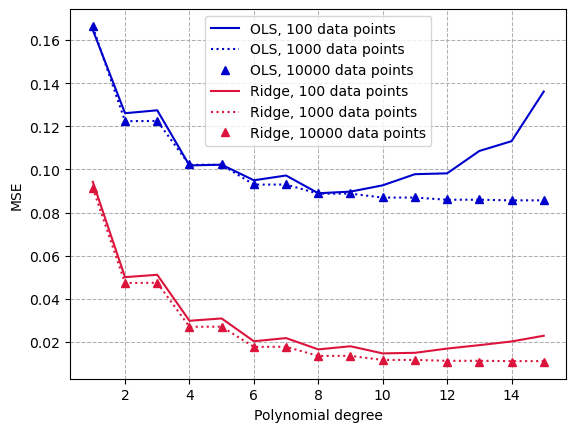

In [6]:
plt.plot(poly_degrees, mean_MSE_datasize_poly_OLS[0,:], "-", color="mediumblue", label=f"OLS, {data_sizes[0]} data points")
plt.plot(poly_degrees, mean_MSE_datasize_poly_OLS[1,:], ":", color="mediumblue", label=f"OLS, {data_sizes[1]} data points")
plt.plot(poly_degrees, mean_MSE_datasize_poly_OLS[2,:], "^", color="mediumblue", label=f"OLS, {data_sizes[2]} data points")
plt.plot(poly_degrees, mean_MSE_datasize_poly_Ridge[0,:], "-", color="crimson", label=f"Ridge, {data_sizes[0]} data points")
plt.plot(poly_degrees, mean_MSE_datasize_poly_Ridge[1,:], ":", color="crimson", label=f"Ridge, {data_sizes[1]} data points")
plt.plot(poly_degrees, mean_MSE_datasize_poly_Ridge[2,:], "^", color="crimson", label=f"Ridge, {data_sizes[2]} data points")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
#plt.title(f"MSE testdata for analytic OLS and Ridge prediction on test data, averaged over {runs} runs, \n"
#          f"ridge_lambda = {ridge_lambda}")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.75)
plt.show()
plt.close()

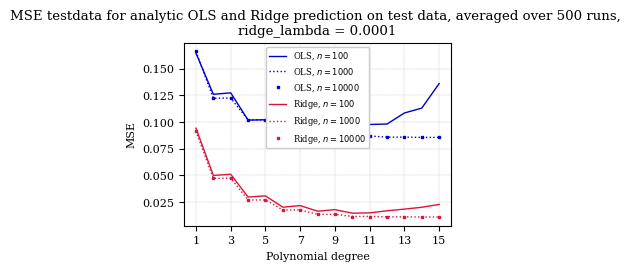

In [27]:
# To make plots fit nicely with two column revtex4 latex report

import matplotlib
from matplotlib.ticker import MultipleLocator

MM_TO_INCH = 1/25.4

matplotlib.rc("text", usetex=False)
plt.rc('lines', linewidth=1.0)
plt.rc("figure", autolayout=True)
plt.rc("legend", fontsize=6)
plt.rc("font", family="serif", size=8)
plt.figure(figsize=(86.78*MM_TO_INCH, 70*MM_TO_INCH))
plt.ticklabel_format(axis = "y", style="sci")
plt.gca().xaxis.set_major_locator(MultipleLocator(base=2, offset=-1))   # Configure the markers on the x axis
plt.grid(True, which="both", linestyle="--", linewidth=0.25)

plt.plot(poly_degrees, mean_MSE_datasize_poly_OLS[0,:], "-", color="mediumblue", label=f"OLS, $n = {data_sizes[0]}$")
plt.plot(poly_degrees, mean_MSE_datasize_poly_OLS[1,:], ":", color="mediumblue", label=f"OLS, $n = {data_sizes[1]}$")
plt.plot(poly_degrees, mean_MSE_datasize_poly_OLS[2,:], "s", markersize="2", color="mediumblue", label=f"OLS, $n = {data_sizes[2]}$")
plt.plot(poly_degrees, mean_MSE_datasize_poly_Ridge[0,:], "-", color="crimson", label=f"Ridge, $n = {data_sizes[0]}$")
plt.plot(poly_degrees, mean_MSE_datasize_poly_Ridge[1,:], ":", color="crimson", label=f"Ridge, $n = {data_sizes[1]}$")
plt.plot(poly_degrees, mean_MSE_datasize_poly_Ridge[2,:], "s", markersize="2", color="crimson", label=f"Ridge, $n = {data_sizes[2]}$")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.title(f"MSE testdata for analytic OLS and Ridge prediction on test data, averaged over {runs} runs, \n"
          f"ridge_lambda = {ridge_lambda}")
plt.legend().get_frame().set_alpha(1.0) # Add solid background (non see thru) to legend box
#plt.savefig("MSE_OLS_Ridge_datasets.pdf", bbox_inches="tight")
plt.show()
plt.close()

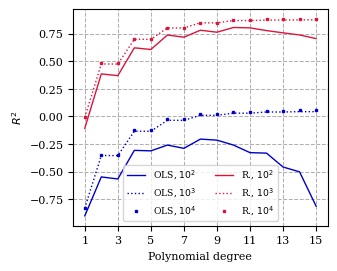

In [57]:
MM_TO_INCH = 1/25.4

matplotlib.rc("text", usetex=False)
plt.rc('lines', linewidth=1.0)
plt.rc("figure", autolayout=True)
plt.rc("legend", fontsize=6)
plt.rc("font", family="serif", size=8)
plt.figure(figsize=(86.78*MM_TO_INCH, 70*MM_TO_INCH))
plt.ticklabel_format(axis = "y", style="sci")
plt.gca().xaxis.set_major_locator(MultipleLocator(base=2, offset=-1))   # Configure the markers on the x axis
plt.grid(True, which="both", linestyle="--", linewidth=0.75)

plt.plot(poly_degrees, mean_R2_datasize_poly_OLS[0,:], "-", color="mediumblue", label=f"OLS, $10^2$")
plt.plot(poly_degrees, mean_R2_datasize_poly_OLS[1,:], ":", color="mediumblue", label=f"OLS, $10^3$")
plt.plot(poly_degrees, mean_R2_datasize_poly_OLS[2,:], "s", markersize="2", color="mediumblue", label=f"OLS, $10^4$")
plt.plot(poly_degrees, mean_R2_datasize_poly_Ridge[0,:], "-", color="crimson", label=f"R., $10^2$")
plt.plot(poly_degrees, mean_R2_datasize_poly_Ridge[1,:], ":", color="crimson", label=f"R., $10^3$")
plt.plot(poly_degrees, mean_R2_datasize_poly_Ridge[2,:], "s", markersize="2", color="crimson", label=f"R., $10^4$")
plt.xlabel("Polynomial degree")
plt.ylabel(f"$R^2$")
# plt.title(f"$R^2$ testdata for analytic OLS and Ridge prediction on test data, averaged over {runs} runs, \n"
#           f"ridge_lambda = {ridge_lambda}")
plt.legend().get_frame().set_alpha(0.8) # Add solid background (non see thru) to legend box
plt.legend(ncol=2, loc="best", fontsize="small")
plt.savefig("R2_OLS_Ridge_datasets.pdf", bbox_inches="tight")
plt.show()
plt.close()

In [ ]:
data_to_save_MSE = np.c_[poly_degrees, mean_MSE_datasize_poly_OLS[0,:], mean_MSE_datasize_poly_OLS[1,:], mean_MSE_datasize_poly_OLS[2,:], mean_MSE_datasize_poly_Ridge[0,:], mean_MSE_datasize_poly_Ridge[1,:], mean_MSE_datasize_poly_Ridge[2,:]]

np.savetxt("data_polyMSE_OLS_Ridge_100_1000_10000_500runs.out", data_to_save_MSE, header="poly_degrees, MSE_OLS_100, MSE_OLS_1000, MSE_OLS_10000, MSE_Ridge_100, MSE_Ridge_1000, MSE_Ridge_10000; 500runs, std. 0.1, ridge_lambda = 0.0001")

In [ ]:
data_to_save_R2 = np.c_[poly_degrees, mean_R2_datasize_poly_OLS[0,:], mean_R2_datasize_poly_OLS[1,:], mean_R2_datasize_poly_OLS[2,:], mean_R2_datasize_poly_Ridge[0,:], mean_R2_datasize_poly_Ridge[1,:], mean_R2_datasize_poly_Ridge[2,:]]

np.savetxt("data_polyR2_OLS_Ridge_100_1000_10000_500runs.out", data_to_save_R2, header="poly_degrees, R2_OLS_100, R2_OLS_1000, R2_OLS_10000, R2_Ridge_100, R2_Ridge_1000, R2_Ridge_10000; 500runs, std. 0.1, ridge_lambda = 0.0001")